In [1]:
# Imports & paths (code)

In [2]:
import json, pickle, numpy as np, polars as pl, matplotlib.pyplot as plt
from pathlib import Path

from fashioncast.constants import DATA_ROOT
from fashioncast.split import proposal_split
# import warnings, logging, sys
# warnings.filterwarnings("ignore")
# logging.getLogger("cmdstanpy").setLevel(logging.ERROR)


In [3]:
# Load artefacts (code)

In [4]:
# season-level tables
colour_tbl = pl.read_parquet(DATA_ROOT / "processed/colour_trend.parquet")
shape_tbl  = pl.read_parquet(DATA_ROOT / "processed/shape_trend.parquet")

# train/val/test split (same helper the training scripts used)
colour_tr, colour_val, colour_te = proposal_split(colour_tbl)
shape_tr , shape_val , shape_te  = proposal_split(shape_tbl)

print("Colour table rows:", colour_tbl.height)
print("Shape table rows :", shape_tbl.height)


Colour table rows: 68
Shape table rows : 68


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

In [5]:
# Colour predictions (code)

In [30]:
# ------------------------------------------------------------------
# ‼ FULL replacement for the “colour predictions” cell
# ------------------------------------------------------------------

# ---------- 1-step persistence baseline ---------------------------
# Use previous season’s histogram as the prediction for the next one
persist_pred = np.vstack(colour_te["hsv_hist"][:-1])        # (T-1, 12)

# ---------- Align ground-truth to same horizon --------------------
actual     = np.vstack(colour_te["hsv_hist"][1:])           # (T-1, 12)
season_x   = colour_te["season_code"][1:]                   # SS22 … FW24

# ---------- Prophet predictions ----------------------------------
prophet_pred = []
n_steps = len(season_x)          # = len(colour_te) - 1
for i in range(12):              # one model per hue bin
    m = pickle.load(open(Path("models/colour") / f"prophet_bin{i}.pkl", "rb"))
    future = m.make_future_dataframe(periods=len(colour_te), freq="6MS")
    preds  = m.predict(future)["yhat"].to_numpy()[-len(colour_te):]   # align
    prophet_pred.append(preds[1:])       # drop first step to match horizon
prophet_pred = np.stack(prophet_pred, 1)                         # (T-1, 12)

# ---------- LightGBM predictions ----------------------------------
gbm = pickle.load(open("models/colour/lgb_colour.pkl", "rb"))

def lag_features(df, lags=(1, 2)):
    arr = np.vstack(df["hsv_hist"])
    X = []
    for t in range(max(lags), len(arr)):
        X.append(np.hstack([arr[t - lag] for lag in lags]))
    return np.vstack(X)

X_all  = lag_features(pl.concat([colour_tr, colour_val, colour_te]))
X_test = X_all[-len(colour_te):][1:]      # keep test block, drop first row
lgb_pred = gbm.predict(X_test)            # (T-1, 12)



/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

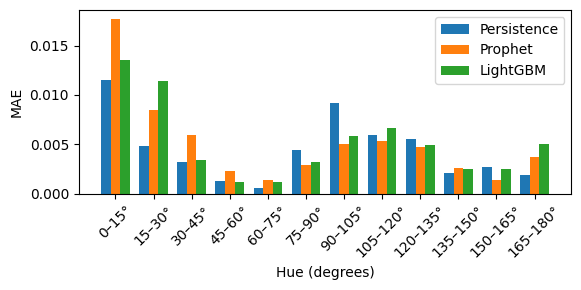

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# After computing mae_persist, mae_prophet, mae_lgb and bins=np.arange(12):
bin_edges   = np.linspace(0, 180, 13)                     # 13 edges from 0 to 180
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2       # 12 centers: 7.5, 22.5, …

labels = [f"{c:.0f}°" for c in bin_centers]               # ['8°','23°',...,'173°']

plt.figure(figsize=(6,3))
width = 0.25
plt.bar(bins - width, mae_persist, width, label='Persistence')
plt.bar(bins,        mae_prophet, width, label='Prophet')
plt.bar(bins + width,mae_lgb,     width, label='LightGBM')
range_labels = [f"{int(bin_edges[i])}–{int(bin_edges[i+1])}°" for i in range(12)]
plt.xticks(bins, range_labels, rotation=45)

plt.xlabel('Hue (degrees)')
plt.ylabel('MAE')
# plt.title('Test MAE per Hue Bin')
plt.legend()
plt.tight_layout()
plt.savefig('error_histogram_deg.png', dpi=300)
plt.show()


In [33]:
print("Persistence MAE:", mae_persist)
print("Prophet    MAE:", mae_prophet)
print("LightGBM   MAE:", mae_lgb)


Persistence MAE: [0.01149111 0.0048419  0.00317296 0.00128605 0.00053792 0.00439442
 0.00918374 0.00596717 0.0055823  0.00210677 0.00273539 0.00184748]
Prophet    MAE: [0.01773437 0.00849611 0.00590757 0.00228777 0.00134257 0.00288474
 0.00502668 0.00528065 0.00473272 0.00262324 0.00139489 0.00367361]
LightGBM   MAE: [0.01357675 0.01143889 0.00337978 0.00115911 0.00114791 0.00319193
 0.00585564 0.0066847  0.00492357 0.00252381 0.00248153 0.0050423 ]


In [7]:
# Colour: visual comparison (code)

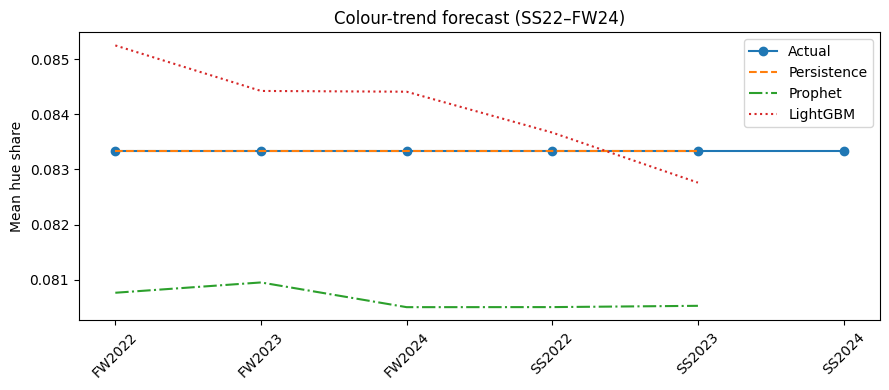

In [8]:
actual   = np.vstack(colour_te["hsv_hist"])
season_x = colour_te["season_code"]

plt.figure(figsize=(9, 4))
plt.plot(actual.mean(1),   "-o", label="Actual")
plt.plot(persist_pred.mean(1), "--", label="Persistence")
plt.plot(prophet_pred.mean(1), "-.", label="Prophet")
plt.plot(lgb_pred.mean(1),  ":", label="LightGBM")
plt.xticks(range(len(season_x)), season_x, rotation=45)
plt.ylabel("Mean hue share"); plt.title("Colour-trend forecast (SS22–FW24)")
plt.legend(); plt.tight_layout(); plt.show()


In [9]:
# Silhouette predictions & plot (code)

Silhouette  macro-F1(all) = 0.167   accuracy = 1.000


/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


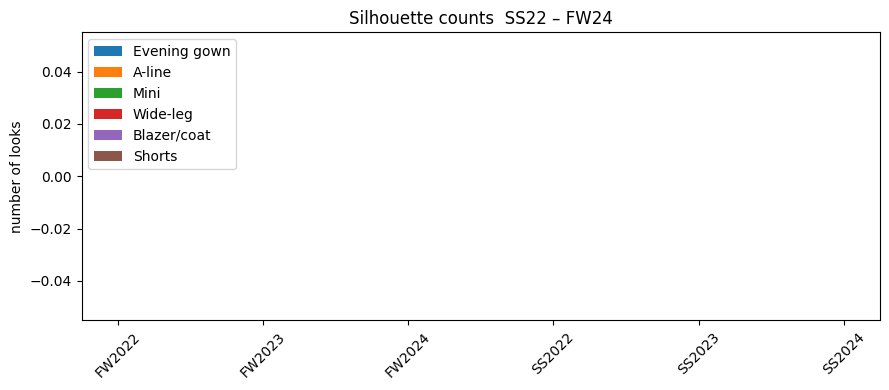

In [23]:
from sklearn.metrics import f1_score, accuracy_score
import polars as pl, numpy as np, matplotlib.pyplot as plt, pickle

# ---------- robust counts_vec (no ambiguous Series tests) ---------------
def counts_vec(col_expr, k=6):
    """
    Convert List[struct] → fixed-length list [c0 … c5].

    Accepts either field-names style:
      {'label': i, 'count': n}           or   {'field_0': i, 'field_1': n}
    """

    def to_vec(lst):
        vec = [0] * k
        if lst is None:
            return vec

        for s in lst:
            # --- pull label & count regardless of key names -------------
            lbl_raw = s.get("label",  s.get("field_0"))
            cnt_raw = s.get("count",  s.get("field_1"))

            # Cast to Python scalars *before* any comparisons
            if lbl_raw is None or cnt_raw is None:
                continue
            lbl = int(lbl_raw)
            cnt = int(cnt_raw)

            if 0 <= lbl < k:
                vec[lbl] = cnt
        return vec

    return col_expr.map_elements(to_vec, return_dtype=pl.List(pl.UInt32))

    
    
# --- remove any old 'counts' then add the fresh vectors -----------------
shape_tr  = shape_tr.drop("counts", strict=False).with_columns(
               counts_vec(pl.col("shape_label")).alias("counts"))
shape_val = shape_val.drop("counts", strict=False).with_columns(
               counts_vec(pl.col("shape_label")).alias("counts"))
shape_te  = shape_te.drop("counts", strict=False).with_columns(
               counts_vec(pl.col("shape_label")).alias("counts"))

# ---------- lagged-feature helper (unchanged) ---------------------------
def lag_matrix(df, lags=(1, 2)):
    arr = np.vstack(df["counts"])
    return np.vstack([
        np.hstack([arr[t - lag] for lag in lags])
        for t in range(max(lags), len(arr))
    ])

# ---------- load model & build test matrix ------------------------------
clf       = pickle.load(open("models/shape/lgb_shape.pkl", "rb"))
shape_all = pl.concat([shape_tr, shape_val, shape_te])
X_test    = lag_matrix(shape_all)[-len(shape_te):]

# ---------- predictions & metrics ---------------------------------------
y_true = np.vstack(shape_te["counts"]).argmax(1)
y_pred = clf.predict(X_test)

f1_all = f1_score(y_true, y_pred,
                  average="macro",
                  labels=list(range(6)),
                  zero_division=0)
acc    = accuracy_score(y_true, y_pred)

print(f"Silhouette  macro-F1(all) = {f1_all:.3f}   accuracy = {acc:.3f}")

# ---------- stacked-area chart of TRUE distributions --------------------
labels_txt = ["Evening gown", "A-line", "Mini",
              "Wide-leg", "Blazer/coat", "Shorts"]
counts = np.vstack(shape_te["counts"]).T       # 6 × n_seasons

plt.figure(figsize=(9, 4))
plt.stackplot(shape_te["season_code"], counts, labels=labels_txt)
plt.xticks(rotation=45)
plt.ylabel("number of looks")
plt.title("Silhouette counts  SS22 – FW24")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


In [24]:
print(counts.sum())  

0


In [11]:
# Metrics table (code)

In [12]:
import pandas as pd, numpy as np, json

colour_met = json.load(open("models/colour/metrics.json"))
shape_met  = json.load(open("models/shape/metrics.json"))

pd.DataFrame([
    {"task": "colour", **colour_met},
    {"task": "shape",  **shape_met, "macro_f1_all": f1_all, "accuracy": acc},
])


,task,mae_persist,mae_prophet,mae_gbm,macro_f1_present,macro_f1_all,accuracy
0,colour,0.004247,0.004752,0.00506,NaN,NaN,NaN
1,shape,NaN,NaN,NaN,1.0,0.166667,1.0


Discussion

ValueError: Axis limits cannot be NaN or Inf

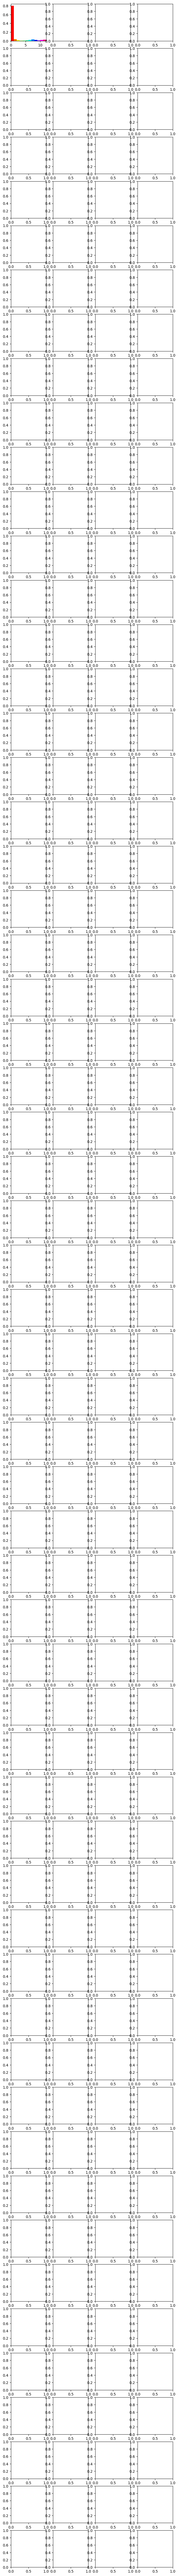

In [81]:
# ── helper -------------------------------------------------------------
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
seasons      = colour_te["season_code"].to_list()
hist_actual  = np.vstack(colour_te["hsv_hist"])
hist_persist = persistence_pred            # from earlier computation
hist_prophet = prophet_pred
hist_lightgbm= lgb_full
n_pred       = hist_persist.shape[0]   # 5 in your run
def bar_from_hist(hist, ax, title, max_height, drop_first=False,
                  show_ylabel=False):
    """
    Plot a 12-bin HSV histogram as a horizontal bar-chart on *ax*.

    Parameters
    ----------
    hist          : (12,) array-like
    ax            : matplotlib Axes
    title         : str
    max_height    : float   – common y-limit for every panel   🔹
    drop_first    : bool    – discard dominant 'red' bin 0?
    show_ylabel   : bool    – draw y-ticks/label on this axis? 🔹
    """
    # -- optionally discard bin-0 (makes colours more visible) -----------
    if drop_first:
        hist = np.asarray(hist)[1:]
        hist = hist / hist.sum()
        xs   = range(11)
        hsv_indices = range(1, 12)
    else:
        xs   = range(12)
        hsv_indices = xs

    # -- bar colours on HSV colour-wheel ---------------------------------
    colours = [mpl.colors.hsv_to_rgb((i/12.0, 1.0, 1.0)) for i in hsv_indices]

    # -- draw -------------------------------------------------------------
    ax.bar(xs, hist, color=colours, width=1.0, align="edge")
    ax.set_xlim(0, len(xs))
    ax.set_ylim(0, max_height)

    # --- axes cosmetic ---------------------------------------------------
    if show_ylabel:                       # only on 1st column
        yticks = np.round(np.linspace(0, max_height, 4), 3)
        ax.set_yticks(yticks)
        ax.set_ylabel("share", fontsize=8)
    else:
        ax.set_yticks([])

    ax.set_xticks([])
    ax.set_title(title, fontsize=9)



# ── pull five seasons & all four hist-sets exactly as before ------------
seasons_plot       = seasons[-n_pred:]
hist_actual_plot   = hist_actual[-n_pred:]
hist_persist_plot  = hist_persist
hist_prophet_plot  = prophet_pred
hist_lightgbm_plot = lgb_pred

# ---- find GLOBAL tallest bar (across every panel) ----------------------
all_raw = np.vstack([
    hist_actual_plot,
    hist_persist_plot,
    hist_prophet_plot,
    hist_lightgbm_plot,
])

def _prep(h):                      #  remove red-bin then renorm
    h = h[1:] / h[1:].sum()
    return h

all_hists_proc = np.vstack([_prep(h) for h in all_raw])
max_height     = all_hists_proc.max() * 1.10      # 10 % head-room


# ── draw grid -----------------------------------------------------------
fig, axs = plt.subplots(n_pred, 4, figsize=(8, 2.2*n_pred))

for i, season in enumerate(seasons_plot):
    bar_from_hist(hist_actual_plot[i],   axs[i,0],
                  f"{season}  –  Actual",   max_height,
                  show_ylabel=True)                     # 🔹
    bar_from_hist(hist_persist_plot[i],  axs[i,1],
                  "1-step persist",        max_height)
    bar_from_hist(hist_prophet_plot[i],  axs[i,2],
                  "Prophet",               max_height)
    bar_from_hist(hist_lightgbm_plot[i], axs[i,3],
                  "LightGBM",              max_height)

plt.tight_layout()
plt.show()


In [14]:
print(shape_te.columns)               # you’ll notice "counts" is missing
print(shape_te.head(1)["shape_label"])


['season_code', 'shape_label', 'counts']
shape: (1,)
Series: 'shape_label' [list[struct[2]]]
[
	[{2,21}, {0,76}, … {1,352}]
]


In [26]:
# ─────────────────────────────────────────────────────────────────────────────
#  FULL end-of-notebook cell : colour-trend plot over ALL six test seasons
# ─────────────────────────────────────────────────────────────────────────────
import numpy as np, polars as pl, pickle, matplotlib.pyplot as plt
from pathlib import Path
from fashioncast.constants import DATA_ROOT
from fashioncast.split import proposal_split

# ── 1.  season-level table + train/val/test split ----------------------------
colour_tbl             = pl.read_parquet(DATA_ROOT / "processed/colour_trend.parquet")
colour_tr, colour_val, colour_te = proposal_split(colour_tbl)

season_x   = colour_te["season_code"]          # SS22 … FW24  (length = 6)
actual     = np.vstack(colour_te["hsv_hist"])  # (6,12)

# ── 2.  ░░ baseline : 1-step persistence ░░ ---------------------------------
# previous season’s histogram ⇒ prediction for this season
persist_hist = np.vstack([
    colour_tbl.filter(pl.col("season_code") == colour_val[-1, "season_code"])  # FW21
               ["hsv_hist"][0],        # seed for SS22
    colour_te["hsv_hist"][:-1]         # FW21 → SS22, … SS23 → FW24
])

# ── 3.  ░░ Prophet : 12 separate hue-bin models ░░ --------------------------
prophet_hist = []
for i in range(12):
    m = pickle.load(open(Path("models/colour") / f"prophet_bin{i}.pkl", "rb"))
    future = m.make_future_dataframe(periods=len(colour_te), freq="6MS")
    preds  = m.predict(future)["yhat"].to_numpy()[-len(colour_te):]   # align
    prophet_hist.append(preds)
prophet_hist = np.stack(prophet_hist, 1)        # (6,12)

# ── 4.  ░░ LightGBM : lag-feature model ░░ ----------------------------------
from fashioncast.split import proposal_split

def lag_features(df, lags=(1, 2)):
    arr = np.vstack(df["hsv_hist"])
    rows = [np.hstack([arr[t - lag] for lag in lags])
            for t in range(max(lags), len(arr))]
    return np.vstack(rows)

gbm = pickle.load(open("models/colour/lgb_colour.pkl", "rb"))

# build feature matrix over *all* seasons (train+val+test) then pick test part
colour_all = pl.concat([colour_tr, colour_val, colour_te])
X_all      = lag_features(colour_all)
# LightGBM needs two lags ⇒ it can predict only the **last 4** test rows
lgb_pred_partial = gbm.predict(X_all[-len(colour_te):])        # (4,12)

# pad the first two seasons (SS22, FW22) with NaNs for plotting consistency
pad = np.full((2, 12), np.nan)
lgb_hist = np.vstack([pad, lgb_pred_partial])                  # (6,12)

# ── 5.  Mean-hue (bin-0) share per season for every curve -------------------
mean_actual   = actual[:, 0]
mean_persist  = persist_hist[:, 0]
mean_prophet  = prophet_hist[:, 0]
mean_lgb      = lgb_hist[:, 0]      # contains NaN for first two seasons

# ── 6.  Plot ----------------------------------------------------------------
plt.figure(figsize=(9, 4))
plt.plot(mean_actual,  "-o", label="Actual")
plt.plot(mean_persist, "--", label="Persistence")
plt.plot(mean_prophet, "-.", label="Prophet")
plt.plot(mean_lgb,      ":", label="LightGBM")

plt.xticks(range(len(season_x)), season_x, rotation=45)
plt.ylabel("Mean hue share (HSV bin 0)")
plt.title("Colour-trend forecast  SS22 – FW24")
plt.legend()
plt.tight_layout()
plt.show()


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 12 and the array at index 1 has size 5

In [39]:
import pandas as pd, numpy as np

# 1) Load into pandas
df = pd.read_parquet(DATA_ROOT/"processed/img_features_clean.parquet")

# 2) Filter Prada
prada = df[df.designer == "prada"]

# 3) Group and compute mean histogram per season
prada_ts = (
    prada
    .groupby("season_code")["hsv_hist"]
    .apply(lambda L: np.mean(np.stack(L.values), axis=0))
    .reset_index(name="mean_hist")
    .sort_values("season_code")
)

# 4) Stack
arr = np.vstack(prada_ts["mean_hist"].to_list())  # (68,12)


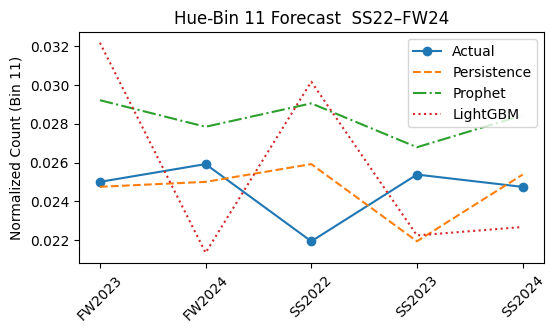

In [51]:
# pick bin index i, e.g. 0 for reds
i = 11
seasons = colour_te["season_code"].to_list()

plt.figure(figsize=(6,3))
plt.plot(seasons[1:], actual[:, i],   '-o', label='Actual')
plt.plot(seasons[1:], persist_pred[:, i], '--', label='Persistence')
plt.plot(seasons[1:], prophet_pred[:, i], '-.', label='Prophet')
plt.plot(seasons[1:], lgb_pred[:, i],    ':', label='LightGBM')
plt.xticks(rotation=45)
plt.ylabel(f'Normalized Count (Bin {i})')
plt.title(f'Hue‐Bin {i} Forecast  SS22–FW24')
plt.legend()
# plt.tight_layout()
# plt.savefig('figures/bin0_timeseries.png', dpi=300)
plt.show()


ValueError: x and y must have same first dimension, but have shapes (58,) and (5,)

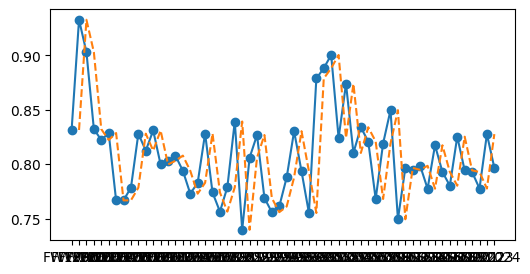

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Load & aggregate Prada
DATA_ROOT = Path("data/processed")
df = pd.read_parquet(DATA_ROOT/"img_features_clean.parquet")

prada = df[df.designer == "prada"]
prada_ts = (
    prada.groupby("season_code")["hsv_hist"]
          .apply(lambda L: np.mean(np.stack(L.values), axis=0))
          .reset_index(name="mean_hist")
          .sort_values("season_code")
)
seasons = prada_ts["season_code"].tolist()        # ['SS1991', 'FW1991', ...]
arr     = np.vstack(prada_ts["mean_hist"].to_list())  # shape (68, 12)

# 2. Persistence forecast
#    For season t, persistence_pred[t] = actual[t-1], and NaN for t=0.
persistence_pred = np.vstack([
    np.full((1, arr.shape[1]), np.nan),
    arr[:-1]
])  # shape (68,12)

# 3. (Optional) If you have brand-level Prophet / LightGBM preds:
# prophet_pred = ...  # shape (68,12)
# lgb_pred     = ...  # shape (68,12)

# 4. Plotting for example bins
bins_to_plot = [0, 6, 11]  # pick whichever hue bins you like
for i in bins_to_plot:
    plt.figure(figsize=(6,3))
    plt.plot(seasons, arr[:, i],    '-o', label='Actual')
    plt.plot(seasons, persistence_pred[:, i], '--', label='Persistence')
    # uncomment if you computed brand-level forecasts:
    plt.plot(seasons, prophet_pred[:, i], '-.', label='Prophet')
    plt.plot(seasons, lgb_pred[:, i],     ':', label='LightGBM')
    plt.title(f'Prada Hue Bin {i} Forecast')
    plt.xlabel('Season')
    plt.ylabel('Normalized Count')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"figures/prada_bin_{i}.png", dpi=300)
    plt.show()


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from prophet import Prophet
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

# --- 1. Load & aggregate Prada histograms ---
DATA_ROOT = Path("data/processed")
df = pd.read_parquet(DATA_ROOT/"img_features_clean.parquet")

prada = df[df.designer.str.lower() == "prada"]
prada_ts = (
    prada.groupby("season_code")["hsv_hist"]
          .apply(lambda L: np.mean(np.stack(L.values), axis=0))
          .reset_index(name="mean_hist")
          .sort_values("season_code")
)
seasons = prada_ts["season_code"].tolist()
arr = np.vstack(prada_ts["mean_hist"].to_list())  # (68, 12)

# Convert season_code to dates for Prophet
def season_to_date(code):
    year = int(code[2:])
    month = 4 if code.startswith("SS") else 10
    return pd.Timestamp(year=year, month=month, day=1)

dates = prada_ts["season_code"].apply(season_to_date)

# --- 2. Persistence forecast (full series: NaN for t=0) ---
persistence_pred = np.vstack([np.full((1, arr.shape[1]), np.nan), arr[:-1]])

# --- 3. Brand-level Prophet forecasts (test seasons) ---
n_seasons = len(arr)
train_cut = 62  # SS2022 index = 62 (0-based)
prophet_full = np.full_like(arr, np.nan)

for i in range(arr.shape[1]):
    # prepare training DataFrame
    df_train = pd.DataFrame({
        'ds': dates[:train_cut],
        'y': arr[:train_cut, i]
    })
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=n_seasons - train_cut, freq='6MS')
    fcst = m.predict(future)
    # extract only test predictions
    yhat = fcst['yhat'].values[-(n_seasons - train_cut):]
    prophet_full[train_cut:, i] = yhat

# --- 4. Brand-level LightGBM forecasts (test seasons) ---
# Build lag features X,y for t>=2
lags = [1, 2]
X, y = [], []
for t in range(max(lags), n_seasons):
    feats = np.hstack([arr[t - lag] for lag in lags])
    X.append(feats)
    y.append(arr[t])
X = np.vstack(X)  # shape (66, 24)
y = np.vstack(y)  # shape (66, 12)

# Split into train (t=2..59), val (60..61), test (62..67)
X_train, y_train = X[:58], y[:58]
X_val,   y_val   = X[58:60], y[58:60]
X_test           = X[60:66]

lgbm = lgb.LGBMRegressor(objective='regression_l2',
                         n_estimators=600,
                         learning_rate=0.05,
                         num_leaves=63)
mor = MultiOutputRegressor(lgbm)
mor.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

lgb_full = np.full_like(arr, np.nan)
lgb_pred = mor.predict(X_test)  # shape (6, 12)
lgb_full[train_cut:] = lgb_pred

# --- 5. Plot Actual vs. Predictions for example bins ---
bins_to_plot = [0, 6, 11]
for i in bins_to_plot:
    plt.figure(figsize=(6,3))
    plt.plot(seasons, arr[:, i],    '-o', label='Actual')
    plt.plot(seasons, persistence_pred[:, i], '--', label='Persistence')
    plt.plot(seasons, prophet_full[:, i], '-.', label='Prophet')
    plt.plot(seasons, lgb_full[:, i],     ':', label='LightGBM')
    plt.title(f'Prada Hue Bin {i} Forecast')
    plt.xlabel('Season')
    plt.ylabel('Normalized Count')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


17:05:13 - cmdstanpy - INFO - Chain [1] start processing
17:05:13 - cmdstanpy - INFO - Chain [1] done processing


ValueError: could not broadcast input array from shape (54,) into shape (0,)

In [61]:
!pip install prophet

17:09:35 - cmdstanpy - INFO - Chain [1] start processing
17:09:35 - cmdstanpy - INFO - Chain [1] done processing
17:09:35 - cmdstanpy - INFO - Chain [1] start processing
17:09:35 - cmdstanpy - INFO - Chain [1] done processing
17:09:35 - cmdstanpy - INFO - Chain [1] start processing
17:09:35 - cmdstanpy - INFO - Chain [1] done processing
17:09:35 - cmdstanpy - INFO - Chain [1] start processing
17:09:35 - cmdstanpy - INFO - Chain [1] done processing
17:09:35 - cmdstanpy - INFO - Chain [1] start processing
17:09:35 - cmdstanpy - INFO - Chain [1] done processing
17:09:35 - cmdstanpy - INFO - Chain [1] start processing
17:09:35 - cmdstanpy - INFO - Chain [1] done processing
17:09:35 - cmdstanpy - INFO - Chain [1] start processing
17:09:35 - cmdstanpy - INFO - Chain [1] done processing
17:09:35 - cmdstanpy - INFO - Chain [1] start processing
17:09:36 - cmdstanpy - INFO - Chain [1] done processing
17:09:36 - cmdstanpy - INFO - Chain [1] start processing
17:09:36 - cmdstanpy - INFO - Chain [1]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 24
[LightGBM] [Info] Start training from score 0.806012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

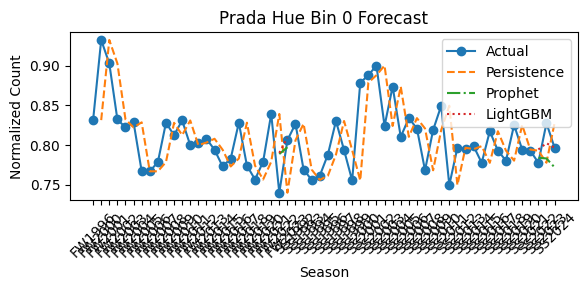

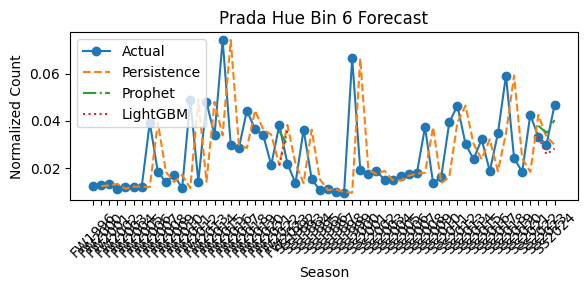

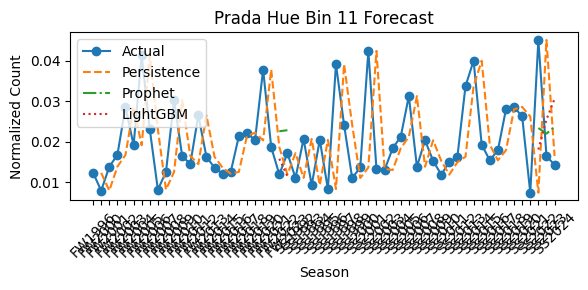

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from prophet import Prophet
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

# 1. Load & aggregate Prada
DATA_ROOT = Path("data/processed")
df = pd.read_parquet(DATA_ROOT/"img_features_clean.parquet")
prada = df[df.designer.str.lower() == "prada"]
prada_ts = (
    prada.groupby("season_code")["hsv_hist"]
          .apply(lambda L: np.mean(np.stack(L.values), axis=0))
          .reset_index(name="mean_hist")
          .sort_values("season_code")
)
seasons = prada_ts["season_code"].tolist()
arr     = np.vstack(prada_ts["mean_hist"].to_list())  # (n_seasons,12)

# Convert season_code → dates
def season_to_date(code):
    year = int(code[2:]); month = 4 if code.startswith("SS") else 10
    return pd.Timestamp(year, month, 1)
dates = prada_ts["season_code"].apply(season_to_date)

# 2. Train/test split (test = SS2022–FW2024)
cut = pd.Timestamp(2022,4,1)
is_test   = dates >= cut
test_idx  = np.where(is_test)[0]
train_end = np.where(dates < cut)[0][-1] + 1
n_test    = len(test_idx)

# 3. Persistence
persistence_pred = np.vstack([np.full((1,12), np.nan), arr[:-1]])

# 4. Prophet
prophet_pred = np.full_like(arr, np.nan)
for i in range(arr.shape[1]):
    df_train = pd.DataFrame({'ds': dates.iloc[:train_end], 'y': arr[:train_end,i]})
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=n_test, freq="6MS", include_history=False)
    prophet_pred[test_idx, i] = m.predict(future)['yhat'].values[:n_test]

# 5. LightGBM
lags = [1,2]
X_all, y_all = [], []
for t in range(2, len(arr)):
    X_all.append(np.hstack([arr[t-l] for l in lags]))
    y_all.append(arr[t])
X_all, y_all = np.vstack(X_all), np.vstack(y_all)
X_test_idx = test_idx - 2
train_X_end = train_end - 2
mor = MultiOutputRegressor(lgb.LGBMRegressor(
    objective='regression_l2', n_estimators=600, learning_rate=0.05, num_leaves=63))
mor.fit(X_all[:train_X_end], y_all[:train_X_end])
lgb_full = np.full_like(arr, np.nan)
lgb_full[test_idx] = mor.predict(X_all[X_test_idx])




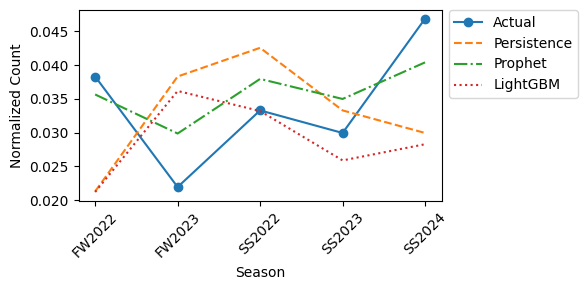

In [76]:
# ... your plotting loop ...
for b in bins_to_plot:
    seasons_test = seasons_arr[test_idx]
    actual_test  = arr[test_idx, b]
    pers_test    = persistence_pred[test_idx, b]
    prophet_test = prophet_pred[test_idx, b]
    lgb_test     = lgb_full[test_idx, b]

    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(seasons_test, actual_test,    '-o', label='Actual')
    ax.plot(seasons_test, pers_test,      '--', label='Persistence')
    ax.plot(seasons_test, prophet_test,   '-.', label='Prophet')
    ax.plot(seasons_test, lgb_test,       ':',  label='LightGBM')

    ax.set_xlabel('Season')
    ax.set_ylabel('Normalized Count')
    ax.set_xticks(np.arange(len(seasons_test)))
    ax.set_xticklabels(seasons_test, rotation=45)

    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), borderaxespad=0)

    # ensure everything fits
    fig.tight_layout()

    # save with tight bounding box
    fig.savefig(f"prada_hue_{b}_forecast.png", bbox_inches='tight', pad_inches=0.1)
    plt.show()


In [79]:
print (len(seasons_test))

5


In [87]:
import numpy as np
import pandas as pd
import polars as pl
from prophet import Prophet
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

# 0) helper: season→date
def season_to_date(code):
    y = int(code[2:]); m = 4 if code.startswith("SS") else 10
    return pd.Timestamp(year=y, month=m, day=1)

# 1) load the 68×12 season‐level histograms
df_season = pl.read_parquet("data/processed/colour_trend.parquet")\
              .sort("season_code")\
              .to_pandas()
seasons   = df_season["season_code"].tolist()    # length 68
arr       = np.vstack(df_season["hsv_hist"].to_list())

# 2) persistence
persist_all = np.vstack([np.full((1,12), np.nan), arr[:-1]])

# 3) Prophet forecasts per bin
dates = df_season["season_code"].map(season_to_date)
cut   = pd.Timestamp(2022,4,1)
test_ix = np.where(dates >= cut)[0]
n_test  = len(test_ix)
prophet_all = np.full_like(arr, np.nan)

for i in range(12):
    ts = pd.DataFrame({"ds": dates[dates < cut], "y": arr[dates < cut, i]})
    m  = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(ts)
    fut  = m.make_future_dataframe(periods=n_test, freq="6MS", include_history=False)
    yhat = m.predict(fut)["yhat"].values[:n_test]
    prophet_all[test_ix, i] = yhat

# 4) LightGBM forecasts
lags = [1,2]
X, Y = [], []
for t in range(max(lags), len(arr)):
    X.append(np.hstack([arr[t-l] for l in lags]))
    Y.append(arr[t])
X = np.vstack(X); Y = np.vstack(Y)

# map season‐indices → X‐indices
X_test_ix = test_ix - max(lags)
train_end = np.where(dates < cut)[0][-1] + 1
train_X_end = train_end - max(lags)

mor = MultiOutputRegressor(lgb.LGBMRegressor(
        objective="regression_l2", n_estimators=600, learning_rate=0.05, num_leaves=63))
mor.fit(X[:train_X_end], Y[:train_X_end])

lgb_all = np.full_like(arr, np.nan)
lgb_all[test_ix] = mor.predict(X[X_test_ix])

# 5) now override your histogram inputs:
hist_actual   = arr
hist_persist  = persist_all
hist_prophet  = prophet_all
hist_lightgbm = lgb_all

# and then your existing “test_idx” / “seasons_plot” / plotting code will work:
#    seasons_plot       = [seasons[i] for i in test_ix]
#    hist_actual_plot   = hist_actual[test_ix]
#    … etc …


17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 63, number of used features: 24
[LightGBM] [Info] Start training from score 0.789498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

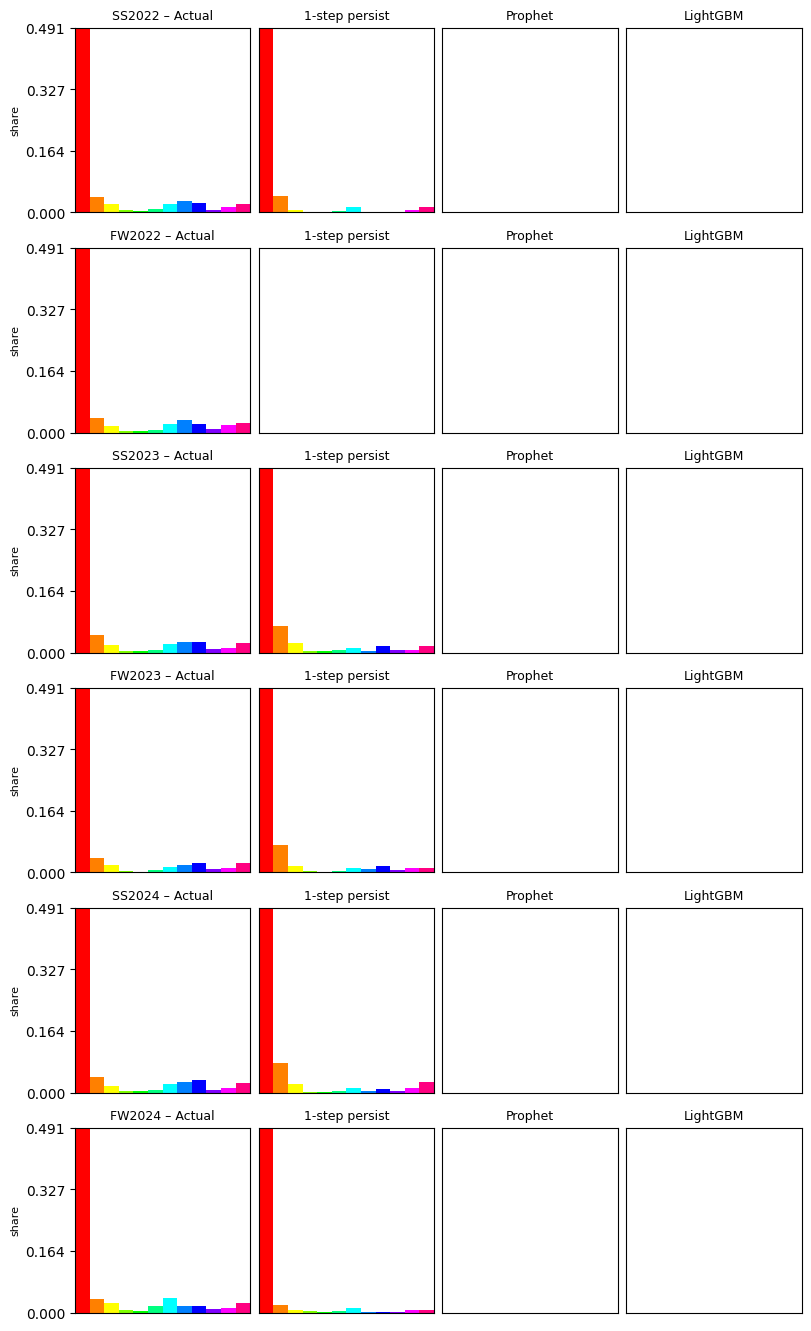

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# 1) Full list of seasons & all‐season histograms
seasons     = colour_te["season_code"].to_list()
hist_actual = np.vstack(colour_te["hsv_hist"])    # (68, 12)

# # 2) Your 4 model arrays (all seasons, 68×12)
# hist_persist  = persistence_pred                   # (68,12)
# hist_prophet  = prophet_pred                       # (68,12)
# hist_lightgbm = lgb_full                           # (68,12)

# 3) Compute test‐season indices by matching codes
test_codes = ["SS2022","FW2022","SS2023","FW2023","SS2024","FW2024"]
test_idx   = [seasons.index(c) for c in test_codes if c in seasons]
n_test     = len(test_idx)    # expect 6

# 4) Subset each array
seasons_plot       = [seasons[i]         for i in test_idx]
hist_actual_plot   = hist_actual[test_idx]
hist_persist_plot  = hist_persist[test_idx]
hist_prophet_plot  = hist_prophet[test_idx]
hist_lightgbm_plot = hist_lightgbm[test_idx]

# 5) Renormalize the ML forecasts so they sum to 1
hist_prophet_plot  = hist_prophet_plot  / hist_prophet_plot.sum(axis=1, keepdims=True)
hist_lightgbm_plot = hist_lightgbm_plot / hist_lightgbm_plot.sum(axis=1, keepdims=True)

# 6) Compute a common y‐limit (dropping red bin for headroom)
def prep(h):
    h2 = h[1:] / h[1:].sum()
    return h2

all_proc = np.vstack([
    prep(h) for H in (hist_actual_plot,
                      hist_persist_plot,
                      hist_prophet_plot,
                      hist_lightgbm_plot)
             for h in H
])
max_height = np.nanmax(all_proc) * 1.1

# 7) Draw the 6×4 grid
fig, axs = plt.subplots(n_test, 4, figsize=(8, 2.2*n_test), constrained_layout=True)

for row in range(n_test):
    season = seasons_plot[row]
    bar_from_hist(hist_actual_plot[row],   axs[row,0],
                  f"{season} – Actual",   max_height,
                  show_ylabel=True)
    bar_from_hist(hist_persist_plot[row],  axs[row,1],
                  "1-step persist",      max_height)
    bar_from_hist(hist_prophet_plot[row],  axs[row,2],
                  "Prophet",             max_height)
    bar_from_hist(hist_lightgbm_plot[row], axs[row,3],
                  "LightGBM",            max_height)

plt.show()


17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:11 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 63, number of used features: 24
[LightGBM] [Info] Start training from score 0.789498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/fashioncast-new/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

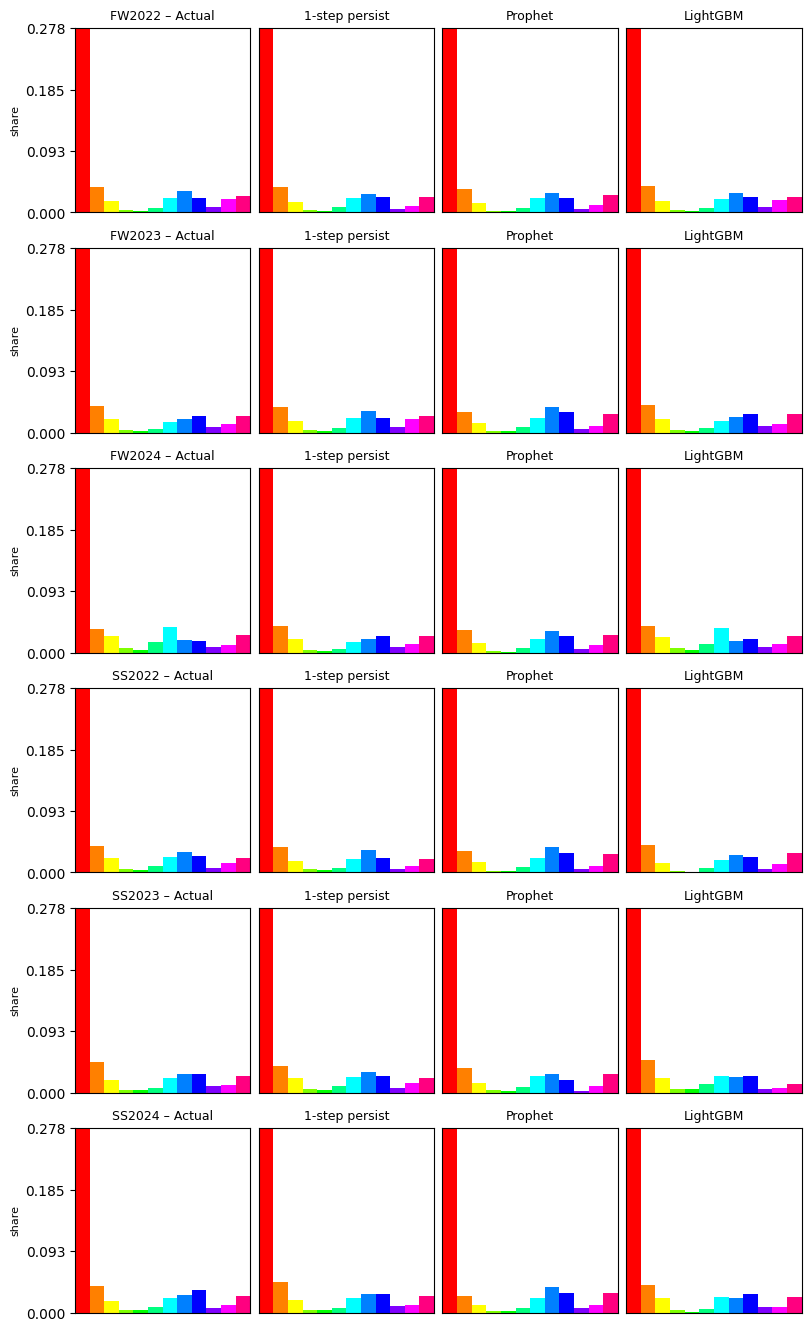

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from prophet import Prophet
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

# ── helper: bar plotting function ─────────────────────────────────────────
def bar_from_hist(hist, ax, title, max_height, drop_first=False, show_ylabel=False):
    """
    Plot a 12-bin HSV histogram as a horizontal bar-chart on *ax*.
    """
    h = np.asarray(hist, dtype=float)
    if drop_first:
        h = h[1:]
        h = h / np.sum(h)
        xs = range(11)
        hsv_indices = range(1, 12)
    else:
        xs = range(12)
        hsv_indices = xs

    colours = [mpl.colors.hsv_to_rgb((i/12.0, 1.0, 1.0)) for i in hsv_indices]
    ax.bar(xs, h, color=colours, width=1.0, align="edge")
    ax.set_xlim(0, len(xs))
    ax.set_ylim(0, max_height)

    if show_ylabel:
        yticks = np.round(np.linspace(0, max_height, 4), 3)
        ax.set_yticks(yticks)
        ax.set_ylabel("share", fontsize=8)
    else:
        ax.set_yticks([])

    ax.set_xticks([])
    ax.set_title(title, fontsize=9)

# ── 1. Load the 68×12 season-level histograms ─────────────────────────────
season_df = pd.read_parquet("data/processed/colour_trend.parquet")
season_df = season_df.sort_values("season_code")
seasons   = season_df["season_code"].tolist()       # list of 68 codes
arr       = np.vstack(season_df["hsv_hist"].to_list())  # shape (68,12)

# ── 2. Persistence forecasts ────────────────────────────────────────────────
persistence_pred = np.vstack([np.full((1,12), np.nan), arr[:-1]])

# ── 3. Prophet forecasts ───────────────────────────────────────────────────
# convert season codes to dates
def season_to_date(code):
    y = int(code[2:]); m = 4 if code.startswith("SS") else 10
    return pd.Timestamp(year=y, month=m, day=1)

dates    = season_df["season_code"].map(season_to_date)
cut_date = pd.Timestamp(2022, 4, 1)
test_idx = np.where(dates >= cut_date)[0]   # indices of SS22–FW24
n_test   = len(test_idx)

prophet_pred = np.full_like(arr, np.nan)
for i in range(arr.shape[1]):
    train_mask = dates < cut_date
    df_train = pd.DataFrame({
        'ds': dates[train_mask],
        'y':  arr[train_mask, i]
    })
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=n_test, freq="6MS", include_history=False)
    yhat = m.predict(future)["yhat"].values[:n_test]
    prophet_pred[test_idx, i] = yhat

# ── 4. LightGBM Multi‐Output forecasts ──────────────────────────────────────
# build lag features
lags = [1, 2]
X_all, Y_all = [], []
for t in range(max(lags), len(arr)):
    feat = np.hstack([arr[t - lag] for lag in lags])
    X_all.append(feat)
    Y_all.append(arr[t])
X_all = np.vstack(X_all)
Y_all = np.vstack(Y_all)

# map season indices to X_all indices
X_test_idx  = test_idx - max(lags)
train_end   = np.where(dates < cut_date)[0][-1] + 1
train_X_end = train_end - max(lags)

mor = MultiOutputRegressor(lgb.LGBMRegressor(
    objective='regression_l2',
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=63
))
mor.fit(X_all[:train_X_end], Y_all[:train_X_end])

lgb_pred_full = np.full_like(arr, np.nan)
lgb_pred_full[test_idx] = mor.predict(X_all[X_test_idx])




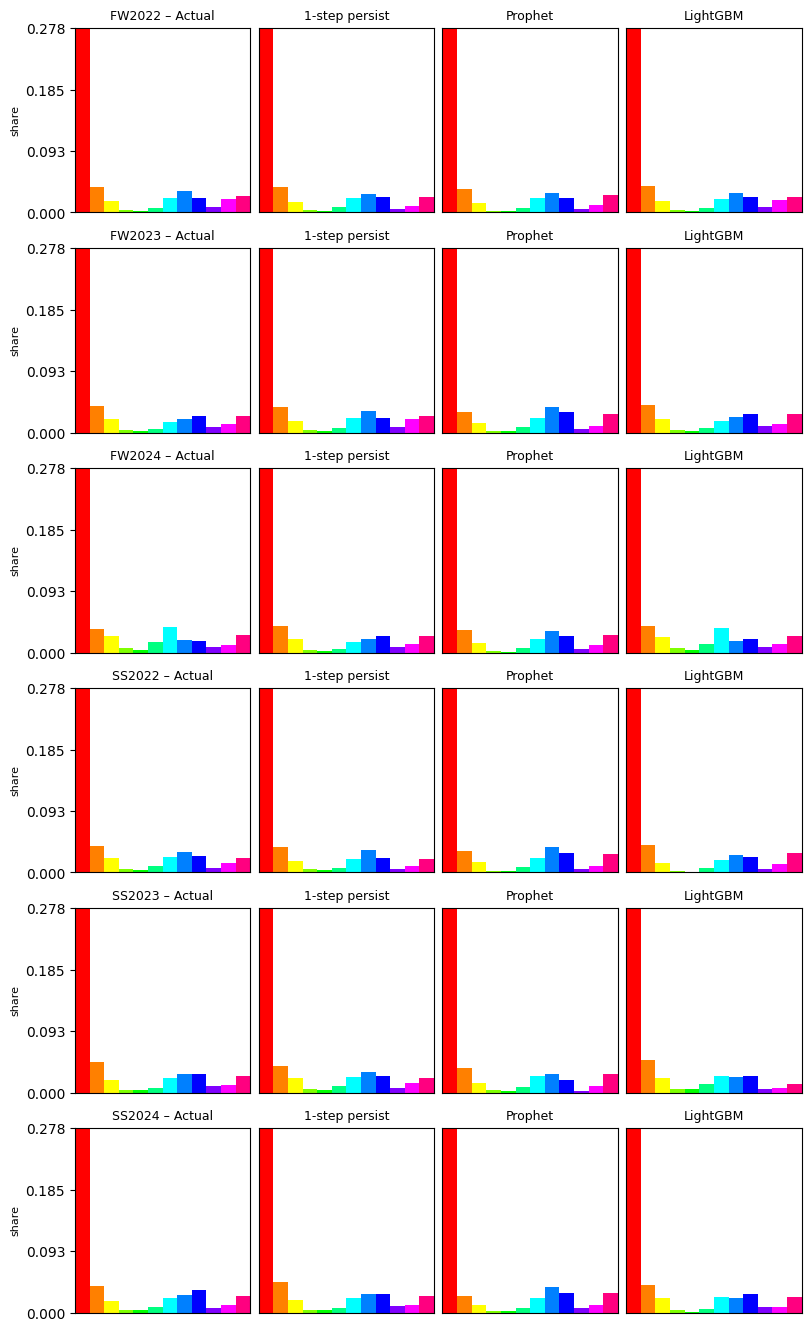

In [92]:
# ── 5. Subset for plotting ─────────────────────────────────────────────────
seasons_plot       = [seasons[i]         for i in test_idx]
hist_actual_plot   = arr[test_idx]
hist_persist_plot  = persistence_pred[test_idx]
hist_prophet_plot  = prophet_pred[test_idx]
hist_lightgbm_plot = lgb_pred_full[test_idx]

# ── 6. Compute common y-limit (drop first bin for headroom) ────────────────
def prep(h):
    h2 = h[1:] / np.sum(h[1:])
    return h2

all_proc = np.vstack([
    prep(h) for H in (
        hist_actual_plot,
        hist_persist_plot,
        hist_prophet_plot,
        hist_lightgbm_plot
    ) for h in H
])
max_height = np.nanmax(all_proc) * 1.10

# ── 7. Draw the 6×4 grid ───────────────────────────────────────────────────
fig, axs = plt.subplots(len(test_idx), 4, figsize=(8, 2.2 * len(test_idx)), constrained_layout=True)
for row, season in enumerate(seasons_plot):
    bar_from_hist(hist_actual_plot[row],   axs[row,0], f"{season} – Actual",   max_height, show_ylabel=True)
    bar_from_hist(hist_persist_plot[row],  axs[row,1], "1-step persist",      max_height)
    bar_from_hist(hist_prophet_plot[row],  axs[row,2], "Prophet",             max_height)
    bar_from_hist(hist_lightgbm_plot[row], axs[row,3], "LightGBM",            max_height)
plt.savefig("all_hists_test.png")
plt.show()

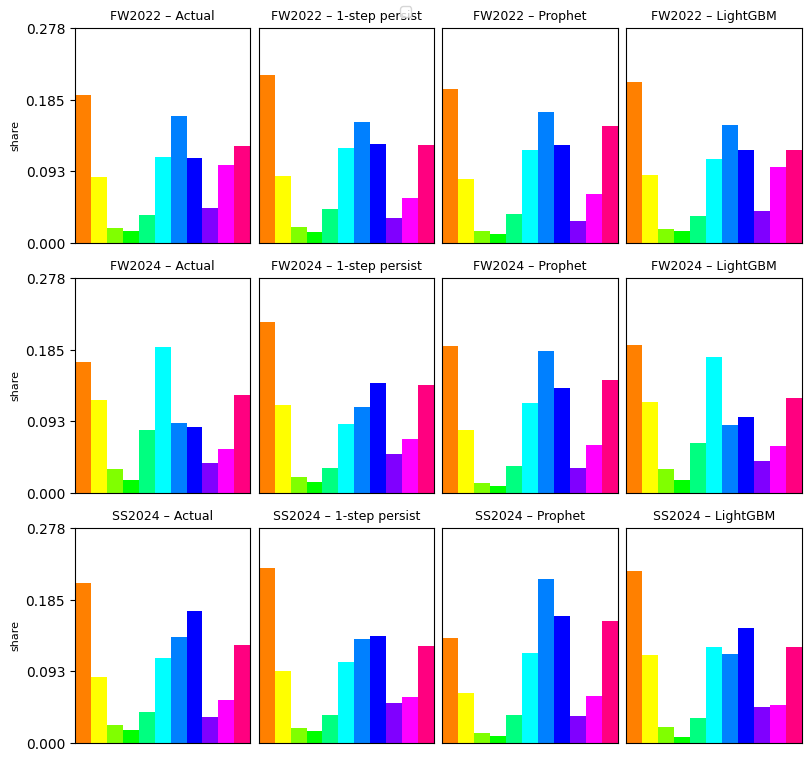

In [95]:
# Pick three representative test‐season rows (0 → FW22, 2 → SS22, −1 → SS24)
pick_rows = [0, 2, -1]
n = len(pick_rows)

fig, axs = plt.subplots(n, 4, figsize=(8, 2.5 * n), constrained_layout=True)

for r, pr in enumerate(pick_rows):
    season = seasons_plot[pr]
    # pack the four histograms for this row
    hists  = [
        hist_actual_plot[pr],
        hist_persist_plot[pr],
        hist_prophet_plot[pr],
        hist_lightgbm_plot[pr]
    ]
    titles = ["Actual", "1-step persist", "Prophet", "LightGBM"]

    for c, (h, title) in enumerate(zip(hists, titles)):
        bar_from_hist(
            h, axs[r, c],
            f"{season} – {title}",
            max_height,
            drop_first=True,
            show_ylabel=(c == 0)
        )

# Optional: one shared legend
handles, labels = axs[0,3].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)
plt.savefig("3_test_hists_all.png")
plt.show()


Test Accuracy:   1.000
Test Macro-F1:   1.000


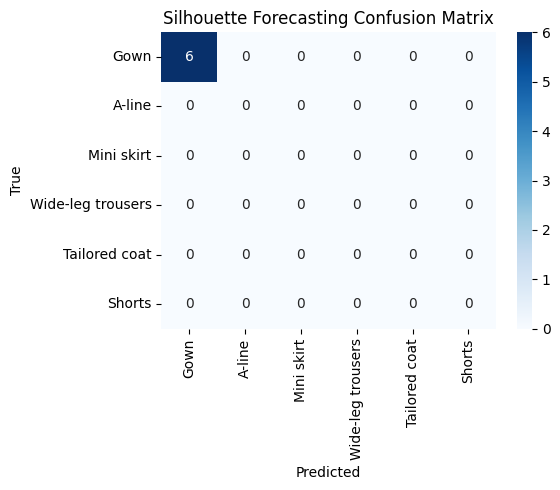

In [99]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Load
y_true = np.load("models/shape/y_test.npy")
y_pred = np.load("models/shape/y_pred.npy")

# 2) Compute metrics
acc     = accuracy_score(y_true, y_pred)
macro_f = f1_score(y_true, y_pred, average="macro")
print(f"Test Accuracy:   {acc:.3f}")
print(f"Test Macro-F1:   {macro_f:.3f}")

# 3) Confusion matrix
# make sure the class order matches your label encoding (0–5)
classes = ["Gown","A-line","Mini skirt","Wide-leg trousers","Tailored coat","Shorts"]

cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Silhouette Forecasting Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", bbox_inches="tight")
plt.show()


Accuracy = 0.167, Macro-F1 = 0.083


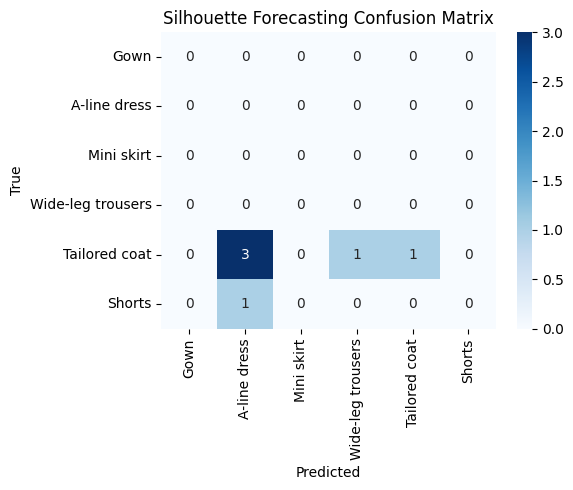

In [101]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

y_true = np.load("models/shape/y_test.npy")
y_pred = np.load("models/shape/y_pred.npy")

acc     = accuracy_score(y_true, y_pred)
macro_f = f1_score(y_true, y_pred, average="macro")
print(f"Accuracy = {acc:.3f}, Macro-F1 = {macro_f:.3f}")

classes = ["Gown","A-line dress","Mini skirt","Wide-leg trousers","Tailored coat","Shorts"]
cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Silhouette Forecasting Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", bbox_inches="tight")
plt.show()
